In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats

pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)

In [2]:
# users = pd.read_csv('../data/Users.csv', delimiter='\x17')
# print(users.shape)
# print(users.head())
# # save users to parquet
# if True:
#     users.to_parquet('../data/Users.parquet')

users = pd.read_parquet("../data/Users.parquet")
users = users.dropna(
    subset=[
        col for col in users.columns if col not in ["AboutMe", "Location", "WebsiteUrl"]
    ]
)
users = users[users.Id > 0]

# creation date and last access date to datetime
users["CreationDate"] = pd.to_datetime(users["CreationDate"])
users["LastAccessDate"] = pd.to_datetime(users["LastAccessDate"])

print(users.shape)
print(users.count())
print(users.head())

(22483017, 12)
AboutMe            2894981
AccountId         22483017
CreationDate      22483017
DisplayName       22483017
DownVotes         22483017
Id                22483017
LastAccessDate    22483017
Location           4220106
Reputation        22483017
UpVotes           22483017
Views             22483017
WebsiteUrl         2398274
dtype: int64
                                              AboutMe  AccountId            CreationDate   DisplayName  DownVotes  Id          LastAccessDate               Location  Reputation  UpVotes   Views                         WebsiteUrl
17  <p><a href="https://blog.codinghorror.com/stac...        1.0 2008-07-31 14:22:31.287   Jeff Atwood       1108   1 2024-02-17 00:51:04.657         El Cerrito, CA       63708     3270  596583     https://blog.codinghorror.com/
18  <p>Dev #2 who helped create Stack Overflow cur...        2.0 2008-07-31 14:22:31.287  Geoff Dalgas         78   2 2024-03-31 23:16:02.157          Corvallis, OR        6156      657   32

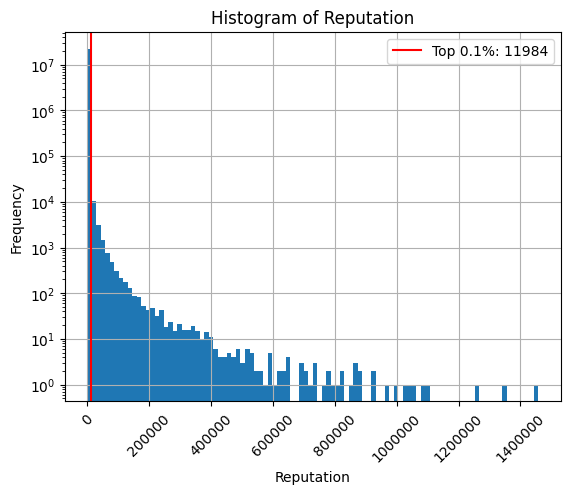

Top 0.1%: 22483
Skewness: 193.88


In [3]:
# histogram of reputation
plt.figure()
users.Reputation.hist(bins=100)

# vertical red line at top
reputation = users.Reputation
reputation = reputation[reputation > 0]
reputation = reputation.sort_values(ascending=False)
percentile = 0.999
top1 = reputation.quantile(percentile)
plt.axvline(x=top1, color="red", label=f"Top {1-percentile:.1%}: {top1:.0f}")

plt.title("Histogram of Reputation")
plt.xlabel("Reputation")
plt.ylabel("Frequency")
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().xaxis.get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.semilogy()
plt.legend()
plt.show()

print(f"Top {1-percentile:.1%}: {reputation[reputation > top1].count()}")
skewness = users.Reputation.skew()
print(f"Skewness: {skewness:.2f}")

In [4]:
most_recent_date = users.CreationDate.max()
print(f"Most recent date: {most_recent_date}")

# getting days since account creation to most recent date
users["DaysSinceCreation"] = (most_recent_date - users.CreationDate).dt.days

# removing users with less than 30 days since creation
users = users[users.DaysSinceCreation >= 30]

# averaging reputation per day
users["ReputationPerDay"] = users.Reputation / users.DaysSinceCreation

# set inf to 0
users["ReputationPerDay"] = (
    users["ReputationPerDay"].replace([np.inf, -np.inf], np.nan).fillna(0)
)

Most recent date: 2024-03-31 23:59:53.407000


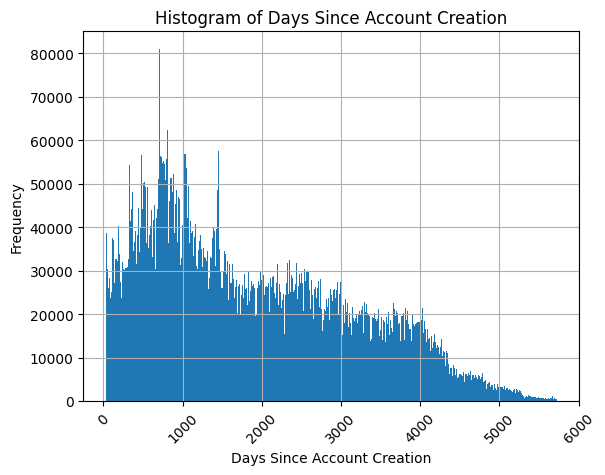

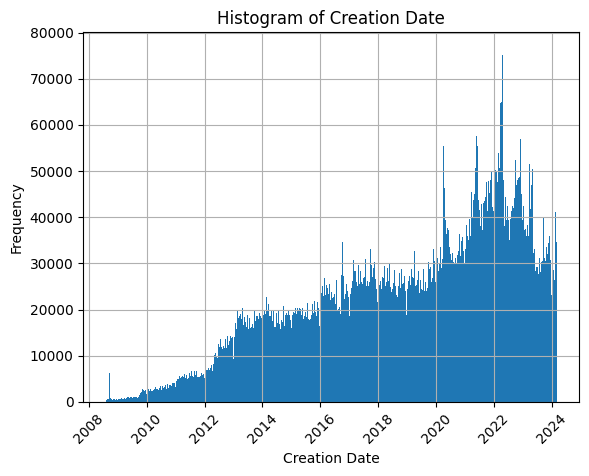

In [5]:
# plot DaysSinceCreation
plt.figure()
users.DaysSinceCreation.hist(bins=1000)
plt.title("Histogram of Days Since Account Creation")
plt.xlabel("Days Since Account Creation")
plt.ylabel("Frequency")
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().xaxis.get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
# plt.semilogy()
plt.show()

plt.figure()
users.CreationDate.hist(bins=1000)
plt.title("Histogram of Creation Date")
plt.xlabel("Creation Date")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

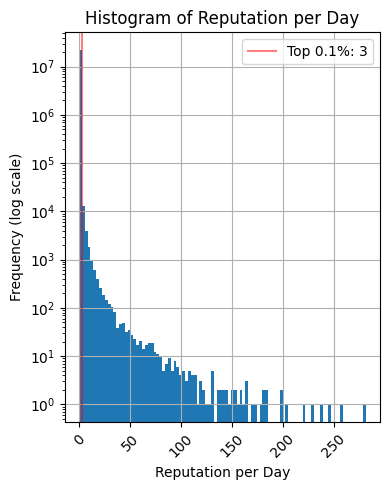

Top 0.1%: 22076
Bottom 99.9%: 22053173
Skewness: 171.70


In [6]:
# histogram of reputation per day
plt.figure(figsize=(4, 5))
users.ReputationPerDay.hist(bins=100)

# vertical red line at top
reputation_per_day = users.ReputationPerDay
reputation_per_day = reputation_per_day[reputation_per_day > 0]
reputation_per_day = reputation_per_day.sort_values(ascending=False)
percentile = 0.999
top1 = reputation_per_day.quantile(percentile)
plt.axvline(x=top1, color="red", label=f"Top {1-percentile:.1%}: {top1:.0f}", alpha=0.5)

plt.title("Histogram of Reputation per Day")
plt.xlabel("Reputation per Day")
plt.ylabel("Frequency (log scale)")
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().xaxis.get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.semilogy()
plt.legend()
plt.tight_layout()
plt.savefig("../plots/reputation_per_day.png")
plt.show()

count_top = reputation_per_day[reputation_per_day > top1].count()
print(f"Top {1-percentile:.1%}: {count_top}")
print(f"Bottom {percentile:.1%}: {reputation_per_day[reputation_per_day <= top1].count()}")
skewness = users.ReputationPerDay.skew()
print(f"Skewness: {skewness:.2f}")

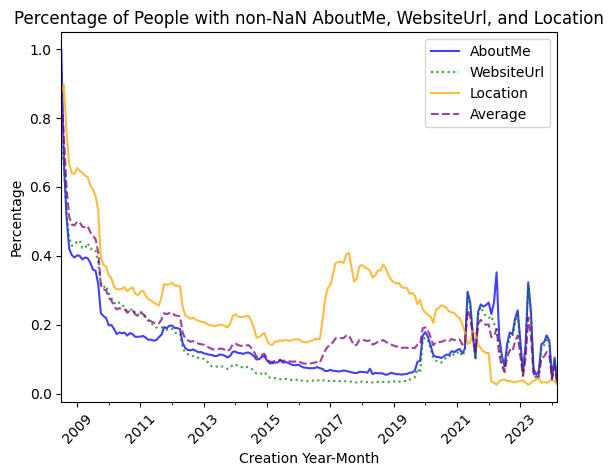

In [7]:
# new col CreationYearMonth which is CreationDate truncated to month
users["CreationYearMonth"] = users.CreationDate.dt.to_period("M")

about_me = users[users.AboutMe.notna()]
about_me_percentage = about_me.groupby("CreationYearMonth").size() / users.groupby("CreationYearMonth").size()
about_me_percentage.plot(label="AboutMe", color='blue', alpha=0.75)

website_url = users[users.WebsiteUrl.notna()]
website_url_percentage = website_url.groupby("CreationYearMonth").size() / users.groupby("CreationYearMonth").size()
website_url_percentage.plot(label="WebsiteUrl", color='green', alpha=0.75, linestyle='dotted')

location = users[users.Location.notna()]
location_percentage = location.groupby("CreationYearMonth").size() / users.groupby("CreationYearMonth").size()
location_percentage.plot(label="Location", color='orange', alpha=0.75)

# average the above 3
avg_percentage = (about_me_percentage + website_url_percentage + location_percentage) / 3
avg_percentage.plot(label="Average", color='purple', alpha=0.75, linestyle='dashed')

# users["NonNanCount"] = users.count(axis=1) / users.shape[1]
# non_nan_count = users.groupby("CreationYearMonth")["NonNanCount"].mean()
# non_nan_count.plot(label="Overall", color='red', alpha=0.75, linestyle='dashed')

# Add plot title and labels
plt.title("Percentage of People with non-NaN AboutMe, WebsiteUrl, and Location")
plt.xlabel("Creation Year-Month")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [8]:
# subset of super-users (top count_top in reputation per day)
super_users = users[users.ReputationPerDay > top1]
# then removing all accounts with DaysSinceCreation < 30
super_users = super_users[super_users.DaysSinceCreation >= 30]
print(f"Super users: {super_users.shape}")

# saving super users to parquet
if True:
    super_users.to_parquet('../data/Users_Super.parquet')

# removing super users from users
users = users[~users.index.isin(super_users.index)]

Super users: (22076, 15)


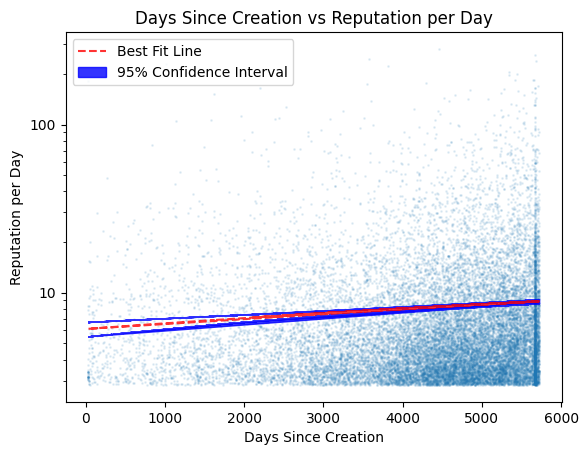

In [9]:

plt.figure()
plt.scatter(super_users.DaysSinceCreation, super_users.ReputationPerDay, s=1, alpha=0.1)

# Fit the line of best fit
x = super_users.DaysSinceCreation.values
y = super_users.ReputationPerDay.values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
y_pred = p(x)
residuals = y - y_pred
n = len(x)
mean_x = np.mean(x)
t = stats.t.ppf(0.975, df=n - 2)

s_err = np.sqrt(np.sum(residuals**2) / (n - 2))

conf_interval = (
    t * s_err * np.sqrt(1 / n + (x - mean_x) ** 2 / np.sum((x - mean_x) ** 2))
)

plt.plot(x, y_pred, "r--", label="Best Fit Line", alpha=0.8)
plt.fill_between(
    x,
    y_pred - conf_interval,
    y_pred + conf_interval,
    color="b",
    alpha=0.8,
    label="95% Confidence Interval",
)

plt.title("Days Since Creation vs Reputation per Day")
plt.xlabel("Days Since Creation")
plt.ylabel("Reputation per Day")
plt.semilogy()
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().xaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.show()

In [10]:
print(len(users))
print(len(super_users))

22053173
22076


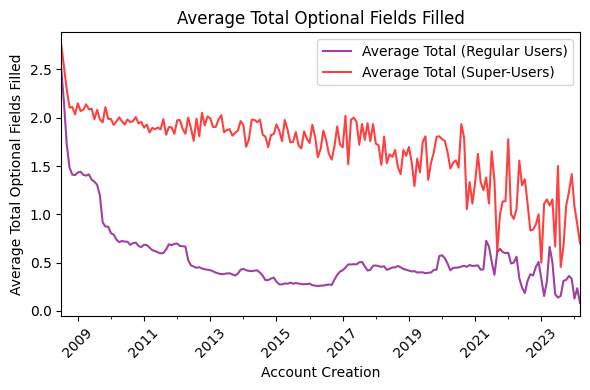

In [18]:
# Add a column to count filled optional fields for super-users
super_users["OptionalFieldsFilled"] = super_users[["AboutMe", "WebsiteUrl", "Location"]].notna().sum(axis=1)

# Calculate average total filled optional fields for super-users
avg_total_optional_super = super_users.groupby("CreationYearMonth")["OptionalFieldsFilled"].mean()

# Add a column to count filled optional fields for all users
users["OptionalFieldsFilled"] = users[["AboutMe", "WebsiteUrl", "Location"]].notna().sum(axis=1)

# Calculate average total filled optional fields for all users
avg_total_optional = users.groupby("CreationYearMonth")["OptionalFieldsFilled"].mean()

plt.figure(figsize=(6, 4))
# Plot average total filled optional fields for regular users and super-users
avg_total_optional.plot(label="Average Total (Regular Users)", color='purple', alpha=0.75, linestyle='solid')
avg_total_optional_super.plot(label="Average Total (Super-Users)", color='red', alpha=0.75, linestyle='solid')

# Add plot title and labels
plt.title("Average Total Optional Fields Filled")
plt.xlabel("Account Creation")
plt.ylabel("Average Total Optional Fields Filled")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("../plots/average_total_optional_fields_filled.png")
plt.show()


          AccountId                   CreationDate      DownVotes            Id                 LastAccessDate    Reputation       UpVotes         Views  DaysSinceCreation  ReputationPerDay
count  2.207600e+04                          22076   22076.000000  2.207600e+04                          22076  2.207600e+04  22076.000000  2.207600e+04       22076.000000      22076.000000
mean   3.003933e+06  2012-04-15 21:00:13.698342144     563.869134  2.526978e+06  2023-07-20 05:16:28.278443776  3.665631e+04   1540.343858  3.848748e+03        4367.677478          8.229294
min    1.000000e+00     2008-07-31 14:22:31.287000       0.000000  1.000000e+00     2008-09-30 07:30:19.520000  9.100000e+01      0.000000  0.000000e+00          30.000000          2.830650
25%    6.738825e+04     2009-10-16 18:04:27.148000      12.000000  2.010855e+05  2024-01-02 14:45:29.150500096  1.528875e+04    318.000000  9.220000e+02        3848.000000          3.532322
50%    4.261410e+05  2011-06-16 19:58:58.369999872

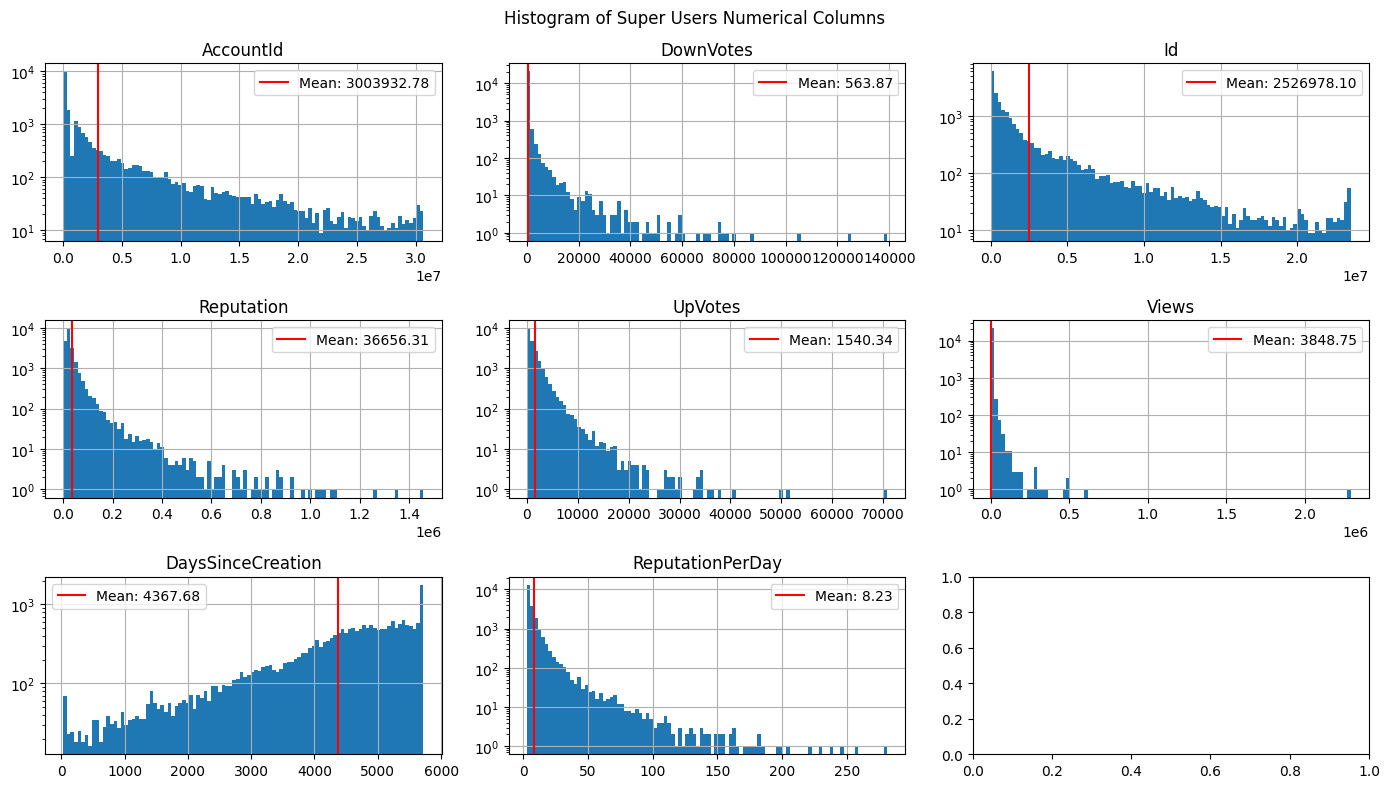

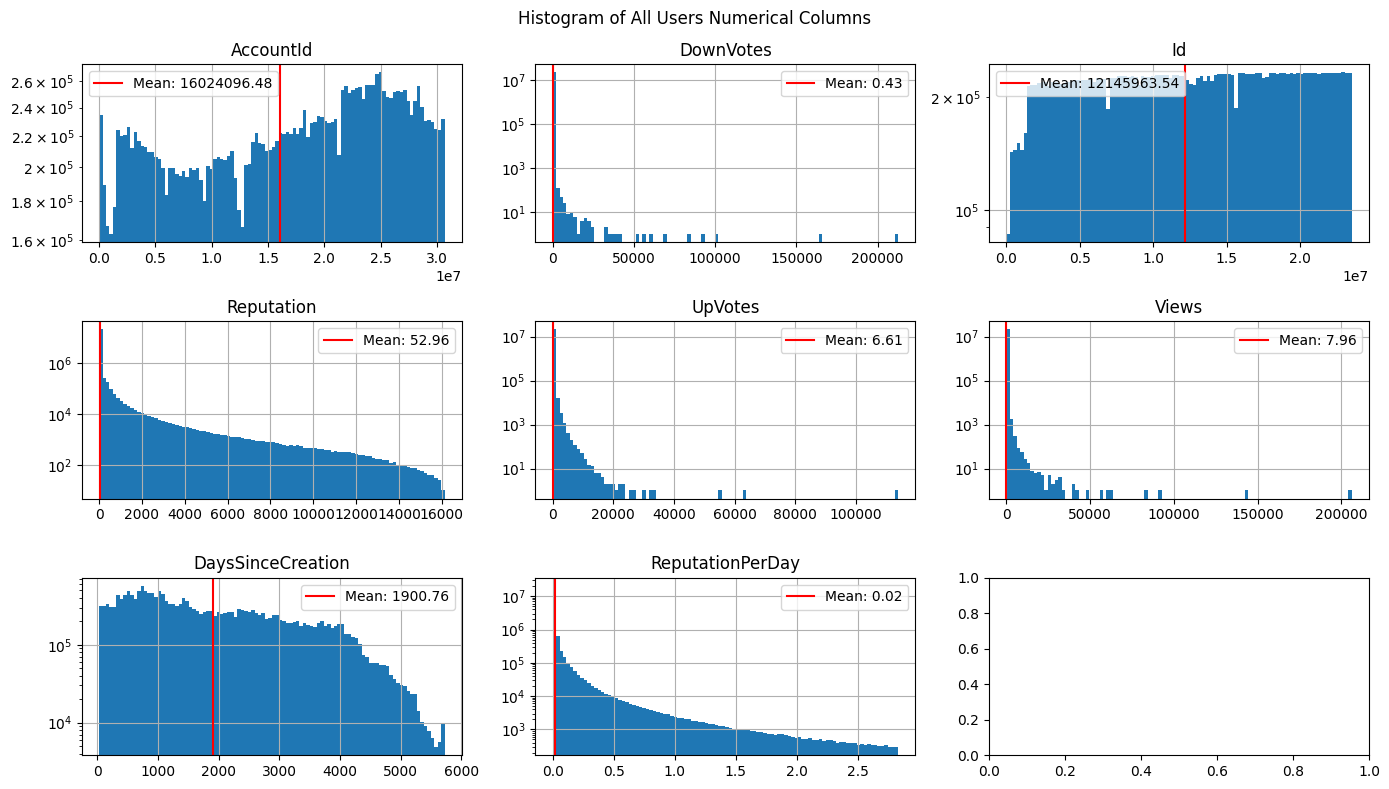

In [14]:
# summary stats for all super-users
print(super_users.describe())

# hist plot for each numerical column
# get number of numerical columns
num_cols = super_users.select_dtypes(include=[np.number]).columns
nrows = 3
ncols = len(num_cols) // nrows + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))
for i, col in enumerate(num_cols):
    ax = axes[i // ncols, i % ncols]
    super_users[col].hist(ax=ax, bins=100)
    cur_mean = super_users[col].mean()
    # vertcal line at mean
    ax.axvline(x=cur_mean, color="red", label=f"Mean: {cur_mean:.2f}")
    ax.set_title(col)
    ax.set_yscale("log")
    ax.legend()
fig.suptitle("Histogram of Super Users Numerical Columns")
plt.tight_layout()
plt.show()

# same for all users
num_cols = users.select_dtypes(include=[np.number]).columns
nrows = 3
ncols = len(num_cols) // nrows + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))
for i, col in enumerate(num_cols):
    ax = axes[i // ncols, i % ncols]
    users[col].hist(ax=ax, bins=100)
    cur_mean = users[col].mean()
    # vertcal line at mean
    ax.axvline(x=cur_mean, color="red", label=f"Mean: {cur_mean:.2f}")
    ax.set_title(col)
    ax.set_yscale("log")
    ax.legend()
fig.suptitle("Histogram of All Users Numerical Columns")
plt.tight_layout()
plt.show()

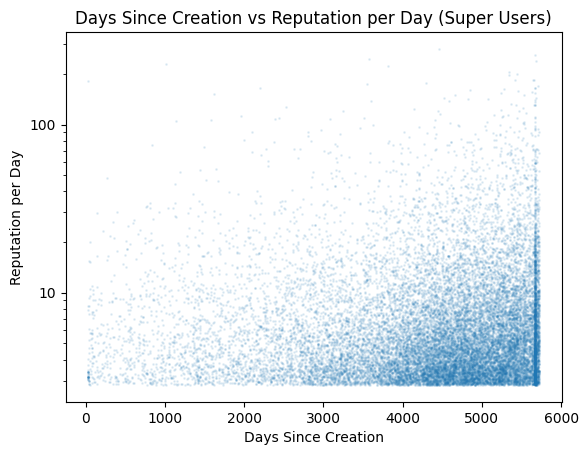

In [18]:
# plotting super user DaysSinceCreation vs ReputationPerDay
plt.figure()
plt.scatter(super_users.DaysSinceCreation, super_users.ReputationPerDay, s=1, alpha=0.1)
plt.title("Days Since Creation vs Reputation per Day (Super Users)")
plt.xlabel("Days Since Creation")
plt.ylabel("Reputation per Day")
plt.semilogy()
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().xaxis.get_major_formatter().set_scientific(False)
plt.show()

In [13]:
# saving all super user ids to csv along with creation date
if True:
    super_users[["Id", "CreationDate"]].to_parquet("../data_users/SuperUserIds.parquet")

# saving all non-super user ids to csv along with creation date
if True:
    users[["Id", "CreationDate"]].to_parquet("../data_users/NonSuperUserIds.parquet")

In [15]:
print(len(super_users))
print(len(users))

print(len(super_users)/len(users))

22076
22053173
0.0010010350891456754
